In [1]:
import os
import cv2
import tensorflow as tf
import torch
from torch import nn
from PIL import Image
import numpy as np
import keras
import math
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from tensorflow.keras.losses import BinaryCrossentropy
from matplotlib import pyplot as plt

In [4]:
train_image_folder_path = '/content/drive/MyDrive/book_covers/train/images'

In [5]:
train_image_files = [f for f in os.listdir(train_image_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [6]:
# Custom function to load and preprocess images
def load_and_preprocess_image(image_folder_path, file_path, target_size=(128, 128)):
    img = cv2.imread(os.path.join(image_folder_path, file_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)  # Resize to a fixed size
    img = img / 255
    return 2*img - 1

In [7]:
# Preprocess all images and store them in a NumPy array
train_processed_images = [load_and_preprocess_image(train_image_folder_path, file) for file in train_image_files]
train_processed_images = np.array(train_processed_images)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_processed_images)
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(128)

In [21]:
def make_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Input((128, 128, 3)))
    model.add(layers.Conv2D(32, (4,4), strides=(1, 1), padding='same', activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (4,4), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Conv2D(32, (4,4), strides=(1, 1), padding='same', activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(128, (4,4), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))


    return model

discriminator = make_discriminator_model()

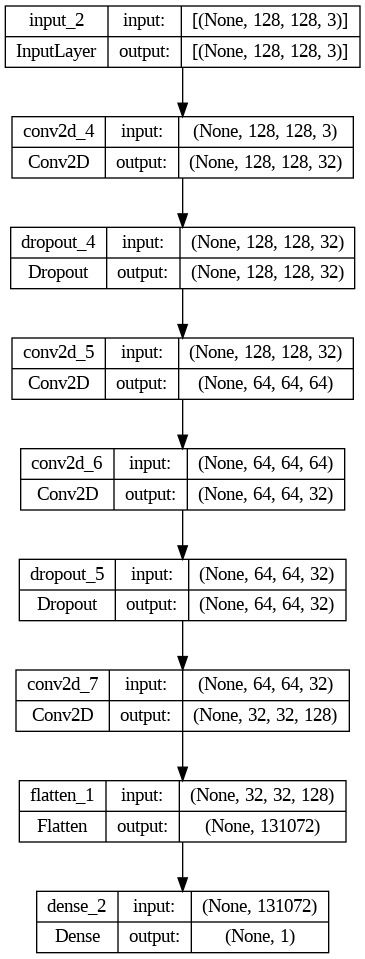

In [22]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [23]:
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(32*32*256, input_dim=512, activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Reshape((32, 32, 256)))
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', activation=layers.LeakyReLU(alpha=0.2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2DTranspose(3, (4,4), strides=(1, 1), padding='same', activation='tanh'))


    return model

generator = make_generator_model()

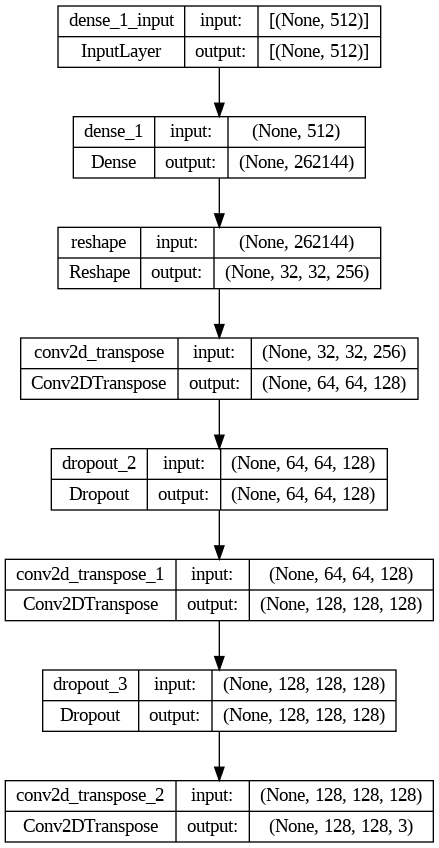

In [12]:
tf.keras.utils.plot_model(generator,show_shapes=True)

## Combine our discriminator and generator to make a GAN

In [24]:
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [25]:
class GAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 512, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.ones_like(yhat_real), tf.zeros_like(yhat_fake)], axis=0)
            noise_real = -0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,512,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [26]:
gan = GAN(generator, discriminator)

gan.compile(g_opt, d_opt, g_loss, d_loss)

In [27]:
hist = gan.fit(train_dataset, epochs=350)

Epoch 1/350
39/39 [==============================] - 17s 366ms/step - d_loss: 0.6901 - g_loss: 0.5822
Epoch 2/350
39/39 [==============================] - 14s 366ms/step - d_loss: 0.6109 - g_loss: 0.8616
Epoch 3/350
39/39 [==============================] - 14s 366ms/step - d_loss: 0.7418 - g_loss: 0.6205
Epoch 4/350
39/39 [==============================] - 14s 367ms/step - d_loss: 0.6679 - g_loss: 0.7046
Epoch 5/350
39/39 [==============================] - 14s 367ms/step - d_loss: 0.7056 - g_loss: 0.5871
Epoch 6/350
39/39 [==============================] - 14s 367ms/step - d_loss: 0.5527 - g_loss: 0.8972
Epoch 7/350
39/39 [==============================] - 14s 368ms/step - d_loss: 0.5974 - g_loss: 0.6617
Epoch 8/350
39/39 [==============================] - 14s 368ms/step - d_loss: 0.7794 - g_loss: 0.4968
Epoch 9/350
39/39 [==============================] - 14s 367ms/step - d_loss: 0.5749 - g_loss: 0.8593
Epoch 10/350
39/39 [==============================] - 14s 367ms/step - d_loss: 0.5

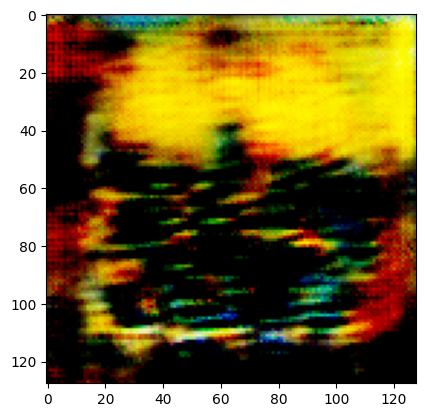

In [29]:
noise = np.random.randn(1, 512)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])

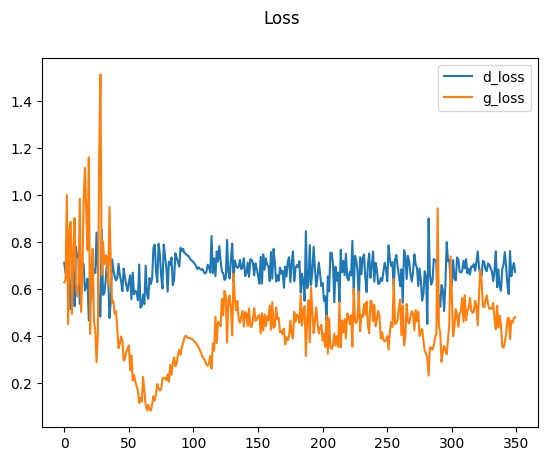

In [30]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [32]:
generator.save('/content/drive/MyDrive/book_covers/generator10.keras')

In [33]:
discriminator.save('/content/drive/MyDrive/book_covers/discriminator10.keras')